In [1]:
# Import packages & setup dataframes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from funky import extractor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, LearningCurveDisplay
from sklearn.metrics import classification_report
from sklearn.inspection import DecisionBoundaryDisplay

In [2]:
# names=['ID', 'M1', 'M2', 'S1', 'S2', 't_pair', 't_elapsed','kick','Mrem', 'Srem', 'esca_v', 'Mcluster', 'gen', 'Z', 'gen_max', 'DV']
df_gc = extractor('gc')
df_nsc = extractor('nsc')
df_ysc = extractor('ysc')

# RFClassifier

## First Generation

The first thing we want is to check if it is possible to predict from the initial conditions - i.e. from the data of the first generation of each BBH - the maximum generation reached by each BBH.

In [3]:
def classes(gen):
    if gen > 3: return 4
    return gen


df_nsc['target'] = df_nsc['gen_max'].transform(classes)
df_nsc['Escaped'] = df_nsc['esca_v'].ge(df_nsc['kick'])  # Escape velocity is greater than kick (bbh stays in cluster)

In [4]:
min_evo = df_nsc.loc[df_nsc.groupby('ID')['gen'].idxmin()]

In [5]:
# separate test set, create label set
dumped_features = ['ID', 'gen', 'gen_max', 'target', 'kick', 'esca_v', 'Mcluster']

x_train, x_test, y_train, y_test = train_test_split((train_feats := min_evo.drop(columns=dumped_features)), min_evo['target'], test_size=0.2)


forest = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=1758, n_jobs=-1, class_weight='balanced')
forest.fit(x_train, y_train)
print(classification_report(y_test, forest.predict(x_test)))
print(f'train size: {len(min_evo)}\ntest size: {len(y_test)}')

              precision    recall  f1-score   support

           2       1.00      1.00      1.00    479831
           3       0.91      0.59      0.72     31815
           4       0.18      0.65      0.28      4300

    accuracy                           0.97    515946
   macro avg       0.70      0.75      0.67    515946
weighted avg       0.99      0.97      0.98    515946

train size: 2579726
test size: 515946


From the scores we can clearly appreciate that the forest is perfectly able to detect BBH that stop at the second generation, it is somewhat also able to classify those that stop at 3rd generation, but utterly fails in classify those that go beyond.

By the graph below, we infer that the main and practically only interesting feature to do the job is the flag $v_{escape} > v_{kick}$, signaling BBH that are not able to merge due to their escape from the cluster.

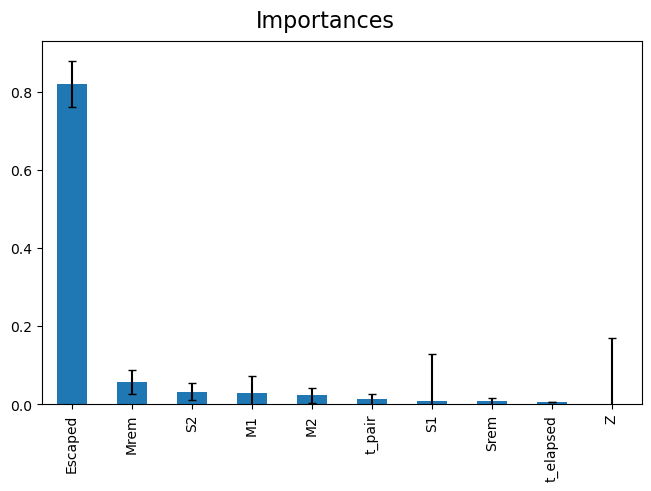

In [6]:
fig, ax = plt.subplots(layout='constrained')
fig.suptitle('Importances', fontsize=16)

importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar(yerr=np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0), capsize=3, ax=ax)
ax.set_ylim(bottom=0)
plt.show()

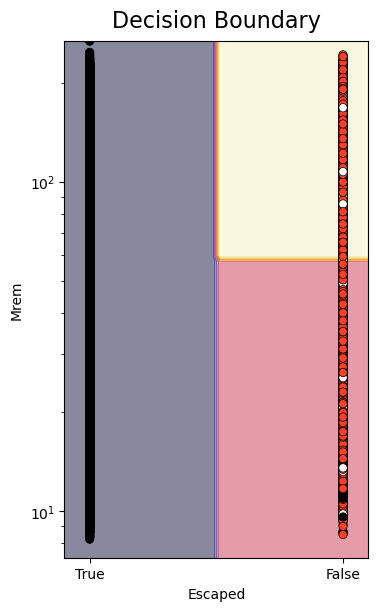

In [7]:
fig, ax = plt.subplots(figsize=(6,6), layout='constrained')
fig.suptitle('Decision Boundary', fontsize=16)

forest.fit(x_train[( important_features := list(importances.index)[:2] )], y_train)
display = DecisionBoundaryDisplay.from_estimator(forest, x_test[important_features], response_method="predict", alpha=.5, cmap='CMRmap', ax=ax)

display.ax_.scatter(x_test[important_features[0]], x_test[important_features[1]], edgecolor='k', c=y_test, lw=.5, cmap='CMRmap')
ax.set_yscale('log')
ax.set_xlim(-.1, 1.1)
ax.set_xticks([0,1], [True, False])
ax.set_aspect(1.3)
plt.show()

## Targeted generation

Acknowledged these results we try to appl

In [8]:
# separate test set, create label set
gen_prec = df_nsc[df_nsc['gen'] == 4]
dumped_features = ['ID', 'gen', 'gen_max', 'target', 'kick', 'esca_v']

x_train, x_test, y_train, y_test = train_test_split((train_feats := gen_prec.drop(columns=dumped_features)), gen_prec['gen_max'] > 4, test_size=0.2)


forest = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1758, n_jobs=-1, class_weight='balanced')
forest.fit(x_train, y_train)
#print(classification_report(fate_test, forest.predict(nsc_test)))
print(f'train size: {len(gen_prec)}\ntest size: {len(y_test)}')
print(forest.score(x_test, y_test))

train size: 21486
test size: 4298
0.9995346672871103


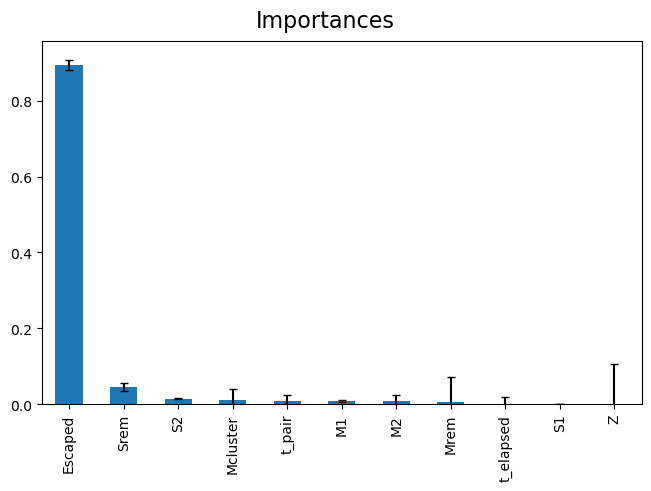

In [9]:
fig, ax = plt.subplots(layout='constrained')
fig.suptitle('Importances', fontsize=16)

importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar(yerr=np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0), capsize=3, ax=ax)
ax.set_ylim(bottom=0)
plt.show()

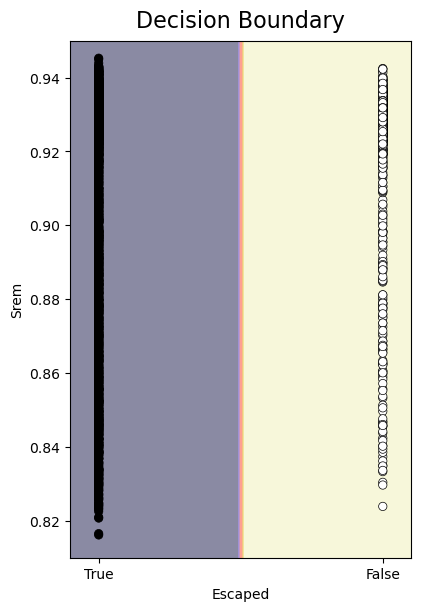

In [24]:
fig, ax = plt.subplots(figsize=(6,6), layout='constrained')
fig.suptitle('Decision Boundary', fontsize=16)

forest.fit(x_train[( important_features := list(importances.index)[:2] )], y_train)
display = DecisionBoundaryDisplay.from_estimator(forest, x_test[important_features], response_method="predict", alpha=.5, cmap='CMRmap', ax=ax)

display.ax_.scatter(x_test[important_features[0]], x_test[important_features[1]], edgecolor='k', c=y_test, lw=.5, cmap='CMRmap')
ax.set_xlim(-.1, 1.1)
ax.set_ylim(.81, .95)
ax.set_xticks([0,1], [True, False])
ax.set_aspect(13)
plt.show()

# RFRegressor

## Spin of the Remnant

In [39]:
dumped_features = ['ID', 'Srem', 'gen_max', 'Escaped', 'target', 'esca_v', 'Mcluster']

x_train, x_test, y_train, y_test = train_test_split((train_feats := df_nsc.drop(columns=dumped_features)), df_nsc['Srem'], test_size=0.2)

forest = RandomForestRegressor(n_estimators=10, max_depth=15, random_state=1758, n_jobs=-1)
forest.fit(x_train, y_train)
print(f'train size: {len(y_train)}\ntest size: {len(y_test)}')
print(forest.score(x_test, y_test))

train size: 2230650
test size: 557663
0.9768626063900913


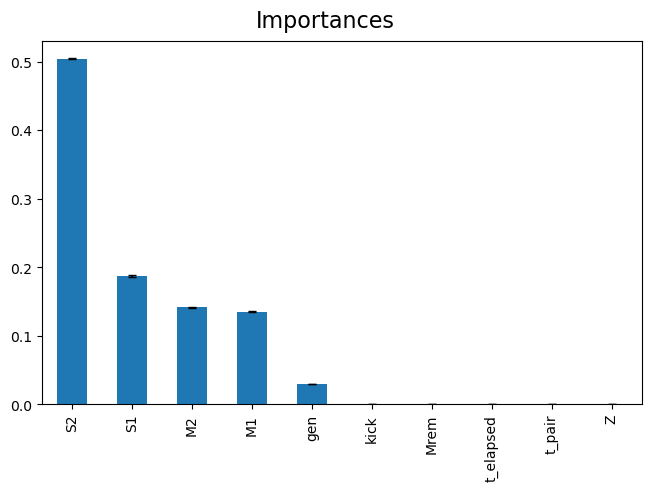

In [40]:
fig, ax = plt.subplots(layout='constrained')
fig.suptitle('Importances', fontsize=16)

importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar(yerr=np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0), capsize=3, ax=ax)
ax.set_ylim(bottom=0)
plt.show()

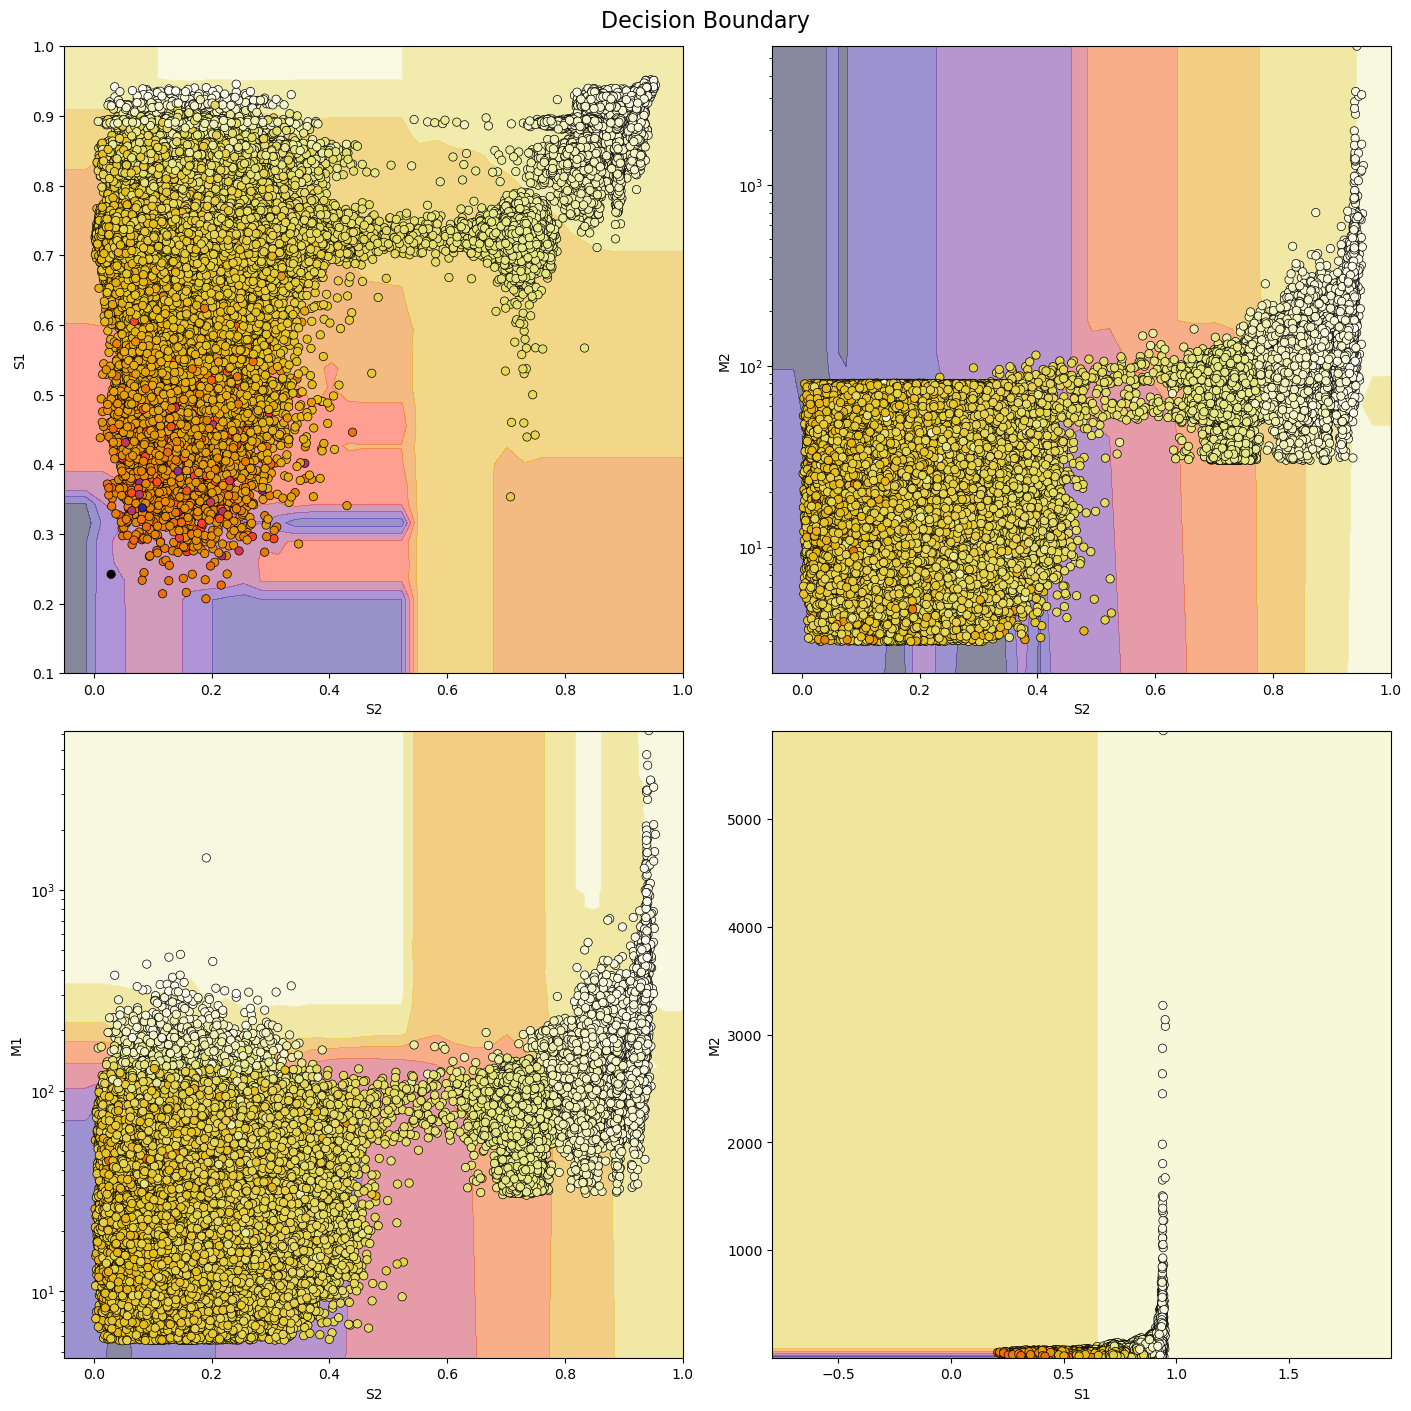

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(14,14), layout='constrained')
fig.suptitle('Decision Boundary', fontsize=16)

forest.fit(x_train[( important_features := list(importances.index[:2]) )], y_train)
display = DecisionBoundaryDisplay.from_estimator(forest, x_test[important_features], response_method="predict", alpha=.5, cmap='CMRmap', ax=ax[0,0])

display.ax_.scatter(x_test[important_features[0]], x_test[important_features[1]], edgecolor='k', c=y_test, lw=.5, cmap='CMRmap')
ax[0,0].set_xlim(-.05, 1)
ax[0,0].set_ylim(0.1, 1)

forest.fit(x_train[( important_features := list(importances.index[[0,2]]) )], y_train)
display = DecisionBoundaryDisplay.from_estimator(forest, x_test[important_features], response_method="predict", alpha=.5, cmap='CMRmap', ax=ax[0,1])

display.ax_.scatter(x_test[important_features[0]], x_test[important_features[1]], edgecolor='k', c=y_test, lw=.5, cmap='CMRmap')
ax[0,1].set_yscale('log')
ax[0,1].set_xlim(-.05, 1)

forest.fit(x_train[( important_features := list(importances.index[[0,3]]) )], y_train)
display = DecisionBoundaryDisplay.from_estimator(forest, x_test[important_features], response_method="predict", alpha=.5, cmap='CMRmap', ax=ax[1,0])

display.ax_.scatter(x_test[important_features[0]], x_test[important_features[1]], edgecolor='k', c=y_test, lw=.5, cmap='CMRmap')
ax[1,0].set_yscale('log')
ax[1,0].set_xlim(-.05, 1)

forest.fit(x_train[( important_features := list(importances.index[[1,2]]) )], y_train)
display = DecisionBoundaryDisplay.from_estimator(forest, x_test[important_features], response_method="predict", alpha=.5, cmap='CMRmap', ax=ax[1,1])

display.ax_.scatter(x_test[important_features[0]], x_test[important_features[1]], edgecolor='k', c=y_test, lw=.5, cmap='CMRmap')


plt.show()

## Mass of the Remnant

In [50]:
dumped_features = ['ID', 'Srem', 'gen_max', 'Escaped', 'target', 'esca_v', 'gen', 'Mrem']

x_train, x_test, y_train, y_test = train_test_split((train_feats := df_nsc.drop(columns=dumped_features)), df_nsc['Mrem'], test_size=0.2)

forest = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1758, n_jobs=-1)
forest.fit(x_train, y_train)
print(f'train size: {len(y_train)}\ntest size: {len(y_test)}')
print(forest.score(x_test, y_test))

train size: 2230650
test size: 557663
0.9981000917457303


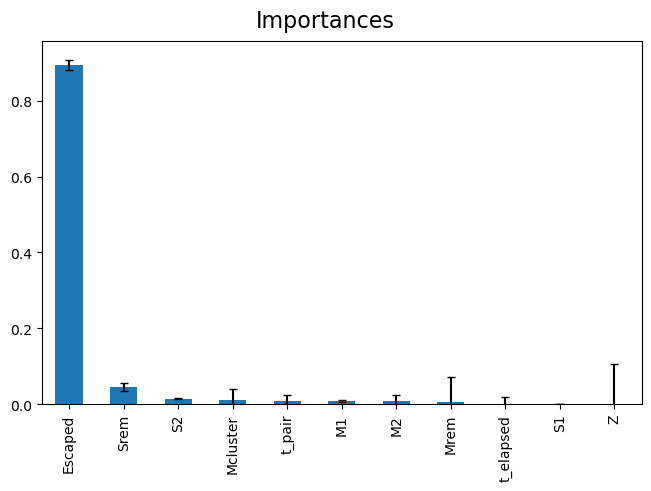

In [9]:
fig, ax = plt.subplots(layout='constrained')
fig.suptitle('Importances', fontsize=16)

importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar(yerr=np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0), capsize=3, ax=ax)
ax.set_ylim(bottom=0)
plt.show()

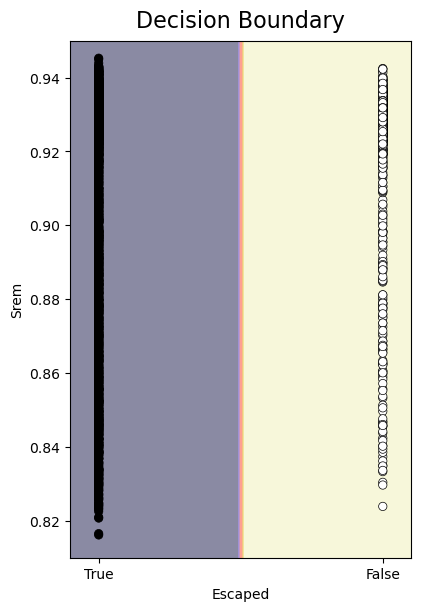

In [24]:
fig, ax = plt.subplots(figsize=(6,6), layout='constrained')
fig.suptitle('Decision Boundary', fontsize=16)

forest.fit(x_train[( important_features := list(importances.index)[:2] )], y_train)
display = DecisionBoundaryDisplay.from_estimator(forest, x_test[important_features], response_method="predict", alpha=.5, cmap='CMRmap', ax=ax)

display.ax_.scatter(x_test[important_features[0]], x_test[important_features[1]], edgecolor='k', c=y_test, lw=.5, cmap='CMRmap')
ax.set_xlim(-.1, 1.1)
ax.set_ylim(.81, .95)
ax.set_xticks([0,1], [True, False])
ax.set_aspect(13)
plt.show()